# Modeling

I'm going to test out a few different models. The most important thing to look for is the recall of each model, since I want to minimize false negative predictions. In the real world, if there is a tornado warning but no tornado, nothing too devastating will happen. However, if there's no warning and a tornado occurs, the consequences could be life-threatening.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, \
                            precision_recall_curve, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
tornado = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_modeling.csv')

In [3]:
tornado_target = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_downsized.csv')

In [4]:
tornado.head()

,LATITUDE,LONGITUDE,ELEVATION,DEWP,GUST,MAX,MIN,MXSPD,PRCP,SLP,STP,TEMP,VISIB,WDSP,SEASON
0,-0.319841,-1.512418,0.318182,0.445570,-0.685393,0.695906,0.325359,-0.475410,0.782609,-0.307692,-0.431818,0.400000,-0.090909,-0.230769,2
1,0.528047,-1.290390,-0.549407,0.470886,-0.438202,0.345029,0.617225,-0.163934,0.000000,-0.353846,0.079545,0.492754,-2.090909,0.641026,3
2,0.534319,-0.620933,-0.519763,0.658228,-0.786517,0.871345,0.712919,-0.836066,-0.043478,-0.107692,0.306818,0.921739,0.090909,-0.384615,2
3,0.000000,-0.614303,0.667984,-0.172152,-0.898876,0.807018,-0.148325,-0.475410,-0.043478,-0.553846,-0.818182,0.278261,0.272727,-0.948718,4
4,-0.471953,0.000000,-0.411067,-0.197468,-0.337079,0.052632,-0.052632,-0.327869,-0.043478,0.384615,0.590909,-0.086957,0.181818,-0.230769,1


I found that the most relevant features were GUST and SLP while testing feature importance. Other features that were less important but still significant to some degree were DEWP, MXSPD, VISIB, and LON. These will be the features that I use during the modeling process.

In [5]:
# list of relevant columns
features = ['GUST', 'SLP', 'DEWP', 'MXSPD', 'VISIB', 'LONGITUDE']

In [6]:
# create X and y variables
X = tornado[features]
y = tornado_target['TORNADO']

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Logistic Regression

In [8]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

y_pred = logreg_cv.predict(X_test)
r2 = logreg_cv.score(X_test, y_test)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Tuned Logistic Regression R squared: {}".format(r2))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Tuned Logistic Regression R squared: 0.8507462686567164
Best score is 0.8902777777777778


In [9]:
# print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cm)
print(cr)

[[99  3]
 [17 15]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       102
           1       0.83      0.47      0.60        32

    accuracy                           0.85       134
   macro avg       0.84      0.72      0.75       134
weighted avg       0.85      0.85      0.83       134



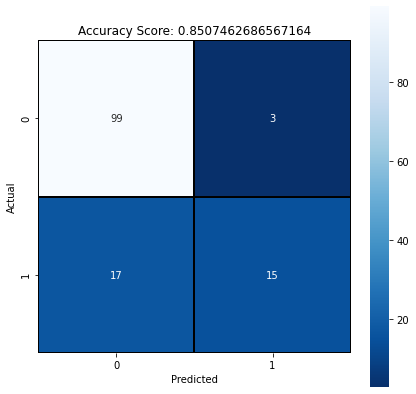

In [10]:
# plot confusion matrix in seaborn heatmap
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(r2)
plt.title(all_sample_title);

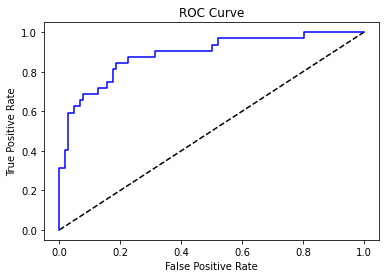

ROC_AUC:  0.8869485294117647


In [11]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

In [12]:
# find best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.200888


# K-Nearest Neighbors

In [13]:
# use cross-validation to check accuracy of each instance
knn_cv = KNeighborsClassifier()
cv_scores = cross_val_score(knn_cv, X, y, cv=5)

# print each accuracy score and the average
print(cv_scores)
print('cv_scores mean: {}'.format(np.mean(cv_scores)))

[0.85046729 0.8317757  0.82242991 0.91588785 0.86915888]
cv_scores mean: 0.8579439252336447


In [14]:
# use GridSearchCV to find best value of C
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(X, y)

print(knn_gscv.best_params_)
print(knn_gscv.best_score_)

{'n_neighbors': 9}
0.8822429906542055


In [15]:
# instantiate final KNN classifier, with optimal n_neighbors value
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_score = knn.score(X_test, y_test)

In [16]:
# print confusion matrix and classification report
cm_knn = confusion_matrix(y_test, y_pred)
cr_knn = classification_report(y_test, y_pred)
print(cm_knn)
print(cr_knn)

[[96  6]
 [11 21]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       102
           1       0.78      0.66      0.71        32

    accuracy                           0.87       134
   macro avg       0.84      0.80      0.82       134
weighted avg       0.87      0.87      0.87       134



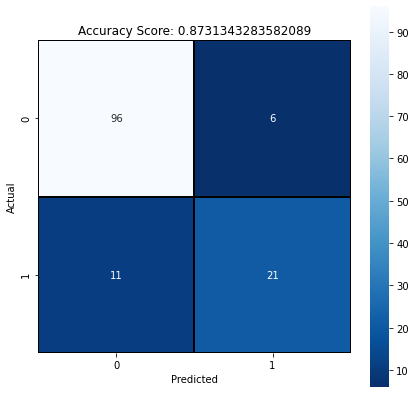

In [17]:
# plot confusion matrix in seaborn heatmap
plt.figure(figsize=(7,7))
sns.heatmap(cm_knn, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(knn_score)
plt.title(all_sample_title);

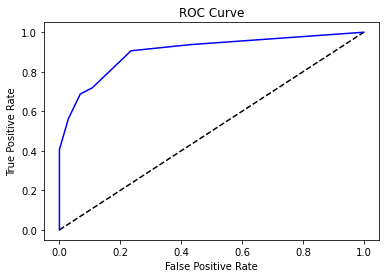

ROC_AUC:  0.901501225490196


In [18]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

In [19]:
# find best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.222222


# Random Forest

Need to do GridSearchCV on RF Classifier like above 2 models

In [20]:
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3,4,5,6,7,8],
    'criterion': ['gini', 'entropy']
}

#rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
#rfc_cv.fit(X_train, y_train)

In [21]:
#rfc_cv.best_params_

In [22]:
rfc_best = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=200, max_depth=8, criterion='gini')
rfc_best.fit(X_train, y_train)
y_pred = rfc_best.predict(X_test)
rfc_score = rfc_best.score(X_test, y_test)

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test, y_pred))

Accuracy for Random Forest on CV data:  0.917910447761194


In [23]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
cm_rfc = confusion_matrix(y_test, y_pred)
cr_rfc = classification_report(y_test, y_pred)
print(cm_rfc)
print(cr_rfc)

[[99  3]
 [ 8 24]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       102
           1       0.89      0.75      0.81        32

    accuracy                           0.92       134
   macro avg       0.91      0.86      0.88       134
weighted avg       0.92      0.92      0.92       134



In [24]:
print(rfc_cv_score)
print("Mean AUC Score: ", rfc_cv_score.mean())

[0.7832981  0.91226216 0.93657505 0.91014799 0.82029598 0.99767442
 0.98604651 0.99534884 0.94264069 0.745671  ]
Mean AUC Score:  0.9029960736937481


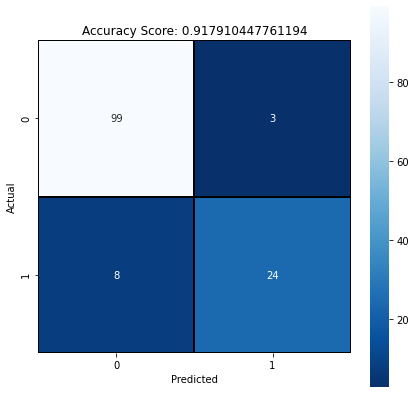

In [25]:
# plot confusion matrix in seaborn heatmap
plt.figure(figsize=(7,7))
sns.heatmap(cm_rfc, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(rfc_score)
plt.title(all_sample_title);

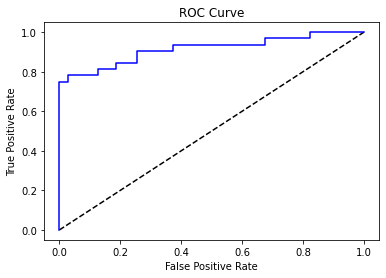

ROC_AUC:  0.914828431372549


In [26]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = rfc_best.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

In [27]:
# find best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.481432


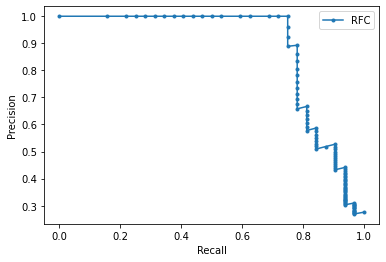

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label='RFC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [29]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.672042, F-Score=0.857


In [31]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.5)

0.915617331134087

# Summary

Of all of the models, the best is probably the Random Forest Classifier. It yields the highest ROC_AUC score, as well as a recall of 0.92, compared to 0.85 and 0.87 for Logistic Regression and K-Nearest Neighbors respectively. Even still, I'd like the recall scores to be higher, since a false negative predicition could be life or death.